### **Importing Libraries**

In [36]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import time
import networkx as nx
import textwrap

### **Loading Dataset**

In [37]:

train_data = pd.read_csv('./Dataset/train_data.csv')
val_data = pd.read_csv('./Dataset/val_data.csv')
test_data = pd.read_csv('./Dataset/test_data.csv')

train_data = train_data.drop(columns=['Address'])
val_data = val_data.drop(columns=['Address'])
test_data = test_data.drop(columns=['Address'])

print(train_data.shape, val_data.shape, test_data.shape)
# print(train_data.head())

(9059, 13) (2265, 13) (2831, 13)


### **Processing Missing Values and Scaling**

In [38]:
def analyze_and_impute(data, dataset_name):
        
    # if(dataset_name == 'Train'):
    #     zero_counts = (data == 0).sum()
    #     total_rows = len(data)

    #     missing_summary = pd.DataFrame({
    #         'Zero Count': zero_counts.drop('FLAG', errors='ignore')
    #     }).sort_values('Zero Count', ascending=False)

    #     print(f"\nMissing Values Summary for {dataset_name} (considering zeros as missing):")
    #     print(f"Total rows: {total_rows}")
    #     print("\nZero counts and percentages by column:")
    #     print(missing_summary)

    #     plt.figure(figsize=(12, 6))
    #     sns.barplot(x=missing_summary.index, y='Zero Count', data=missing_summary)
    #     plt.xticks(rotation=45, ha='right')
    #     plt.title(f'Percentage of Zero Values by Column - {dataset_name}')
    #     plt.tight_layout()
    #     plt.show()

    #     columns_to_impute = data.columns.difference(['FLAG'])

    
    #     data = data.loc[~(data[columns_to_impute].sum(axis=1) == 0)].copy()
        
    #     print(f"Rows with all zeros removed in {dataset_name}.")
    #     print(f"Updated dataset shape: {data.shape}")

    #     for column in columns_to_impute:
    #         median_value = data.loc[data[column] != 0, column].median()
    #         data.loc[:, column] = data[column].replace(0, median_value)

    #     print(f"Imputation completed for {dataset_name}. Zeros replaced with column medians.")
    
    columns_to_impute = data.columns.difference(['FLAG'])

    scaler = MinMaxScaler()
    data[columns_to_impute] = scaler.fit_transform(data[columns_to_impute])

    print("Feature scaling completed for columns with large ranges.")

    return data

In [39]:
train_data = analyze_and_impute(train_data, "Train")
val_data = analyze_and_impute(val_data, "Validation")
test_data = analyze_and_impute(test_data, "Test")

Feature scaling completed for columns with large ranges.
Feature scaling completed for columns with large ranges.
Feature scaling completed for columns with large ranges.


### **Visualization**

In [40]:
def plot_correlation_matrix(data, dataset_name):

    correlation_matrix = data.corr()

    plt.figure(figsize=(8, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f"Correlation Matrix of Features (Including FLAG) - {dataset_name}")
    plt.show()


def plot_violin_plots(data, dataset_name):

    columns_to_plot = data.columns.difference(['FLAG'])

    plt.figure(figsize=(10, len(columns_to_plot) * 3))

    for idx, column in enumerate(columns_to_plot, 1):
        plt.subplot(len(columns_to_plot), 1, idx)
        sns.violinplot(x='FLAG', y=column, data=data, palette='coolwarm', scale='width')
        plt.title(f'Violin Plot of {column} by FLAG - {dataset_name}')
        plt.tight_layout()

    plt.show()

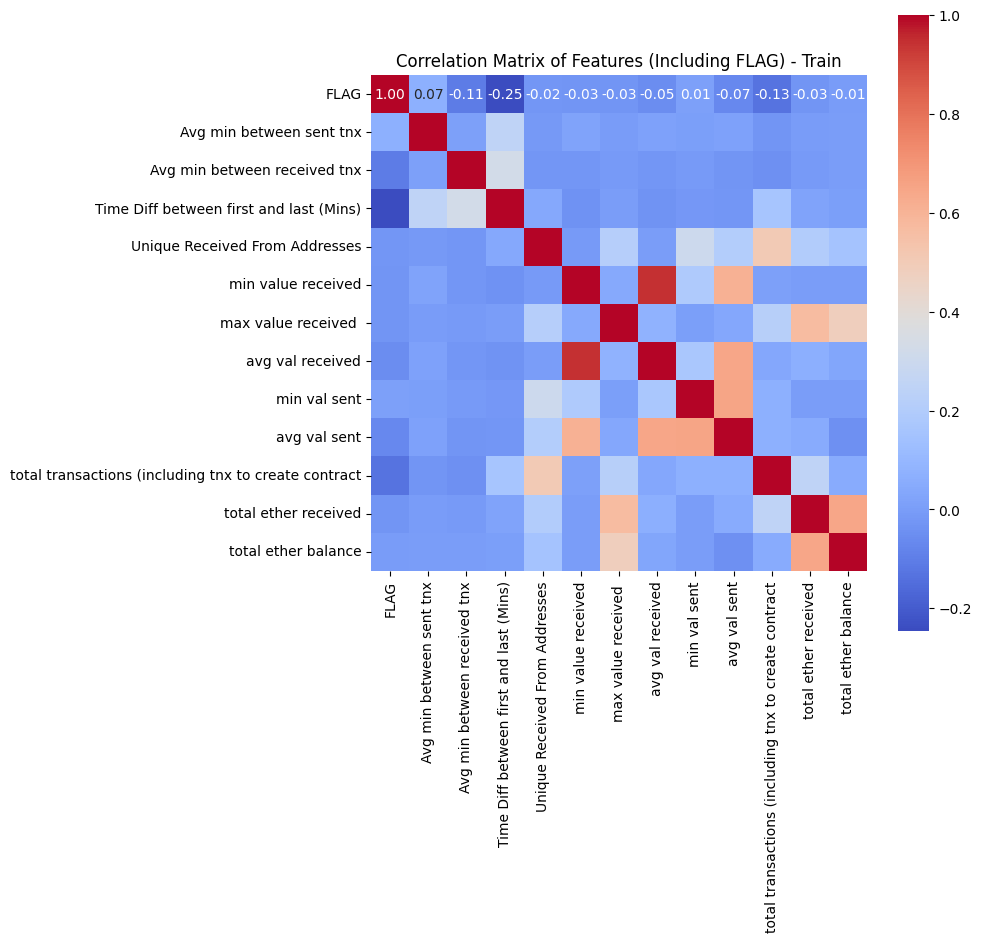

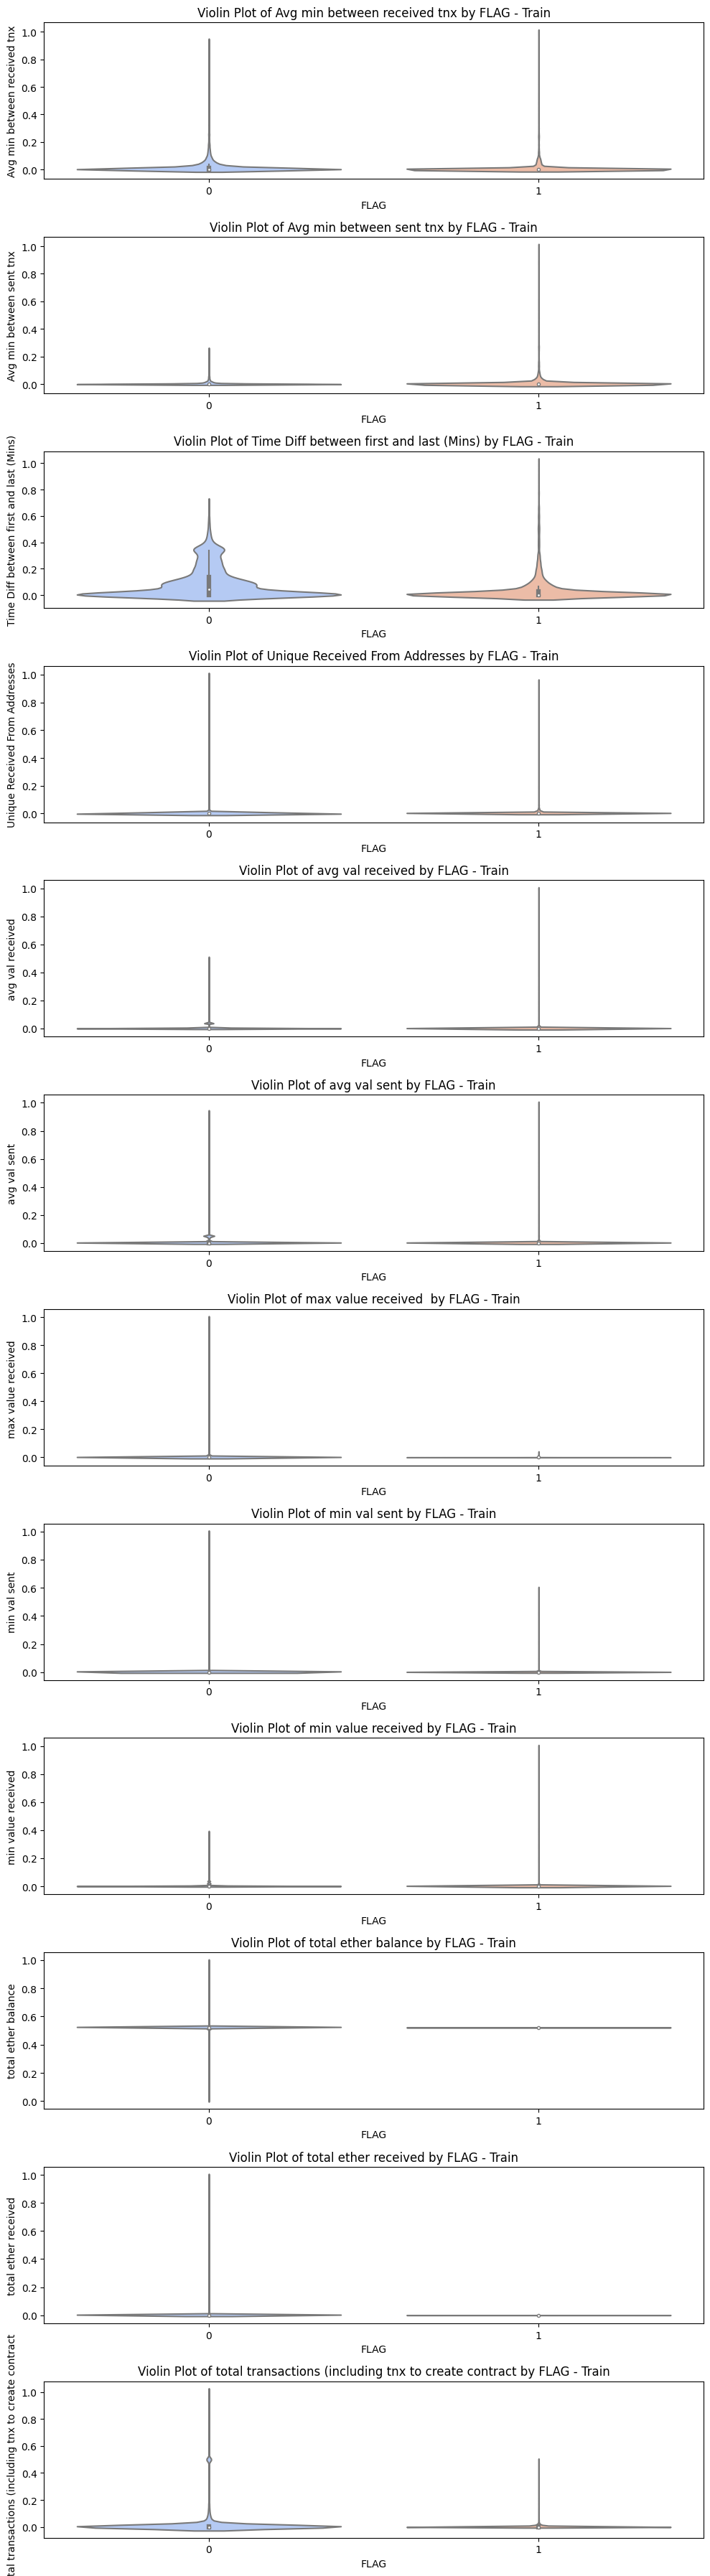

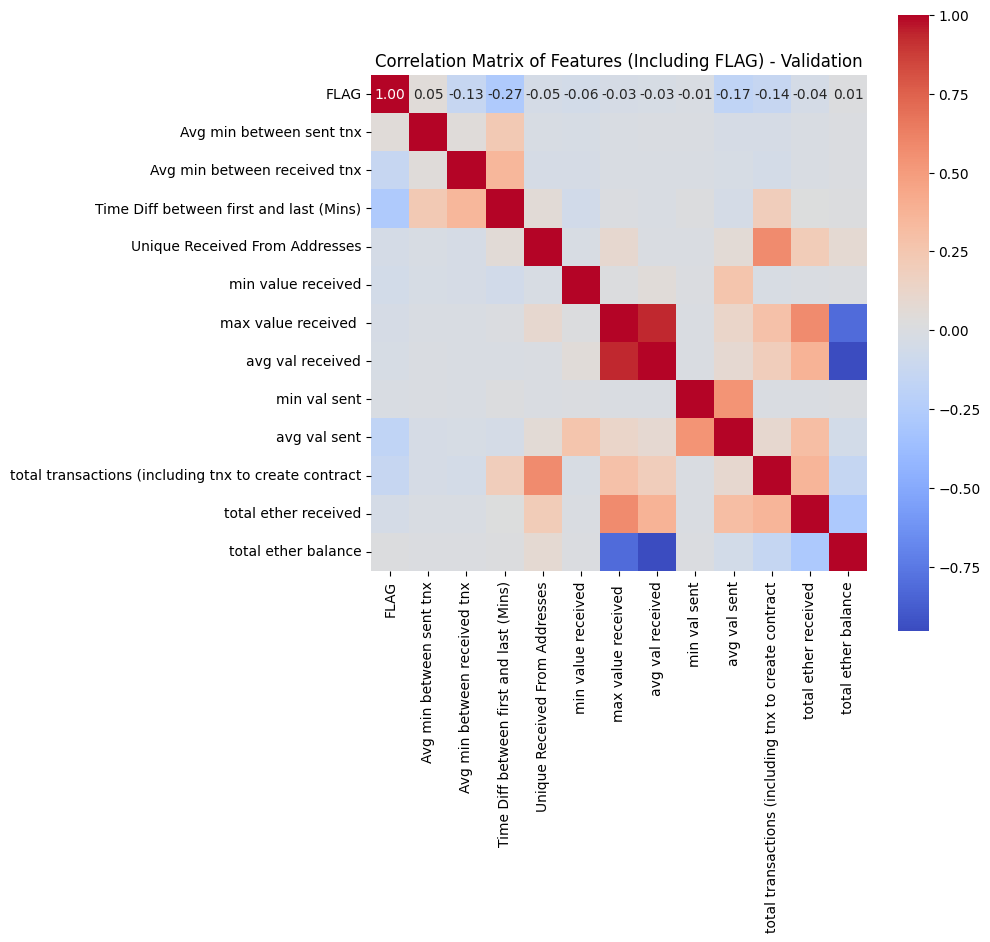

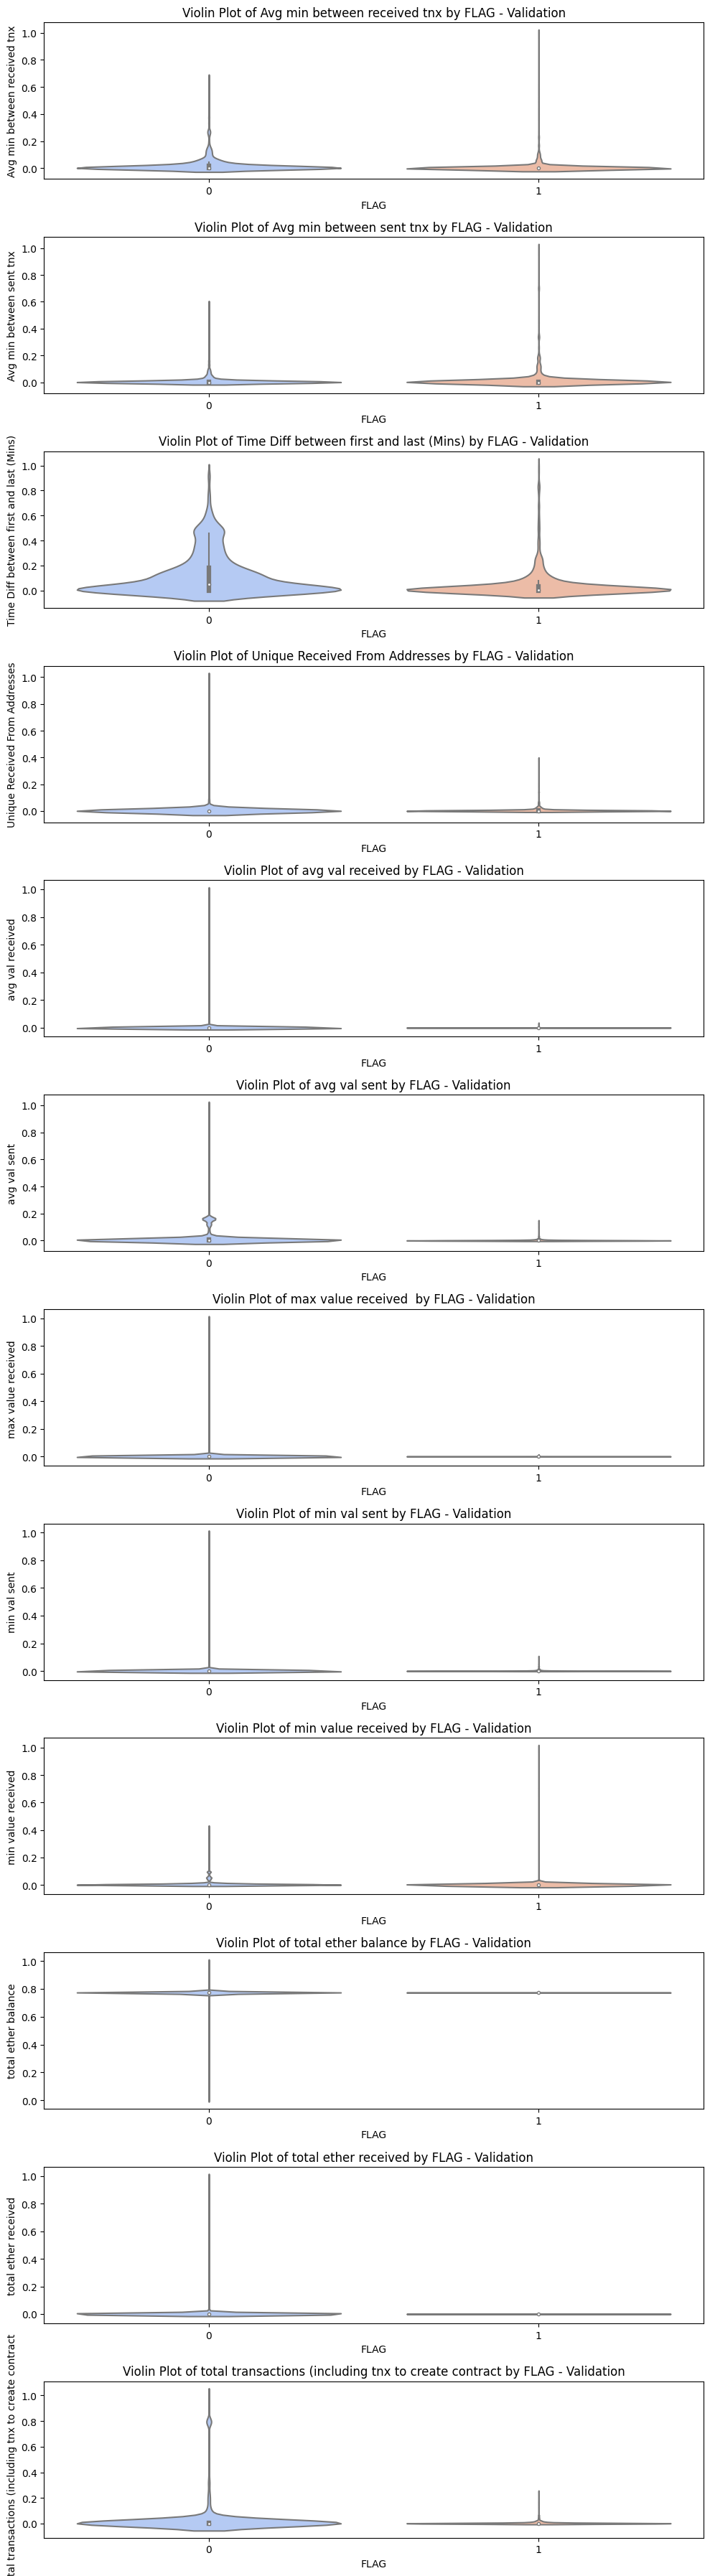

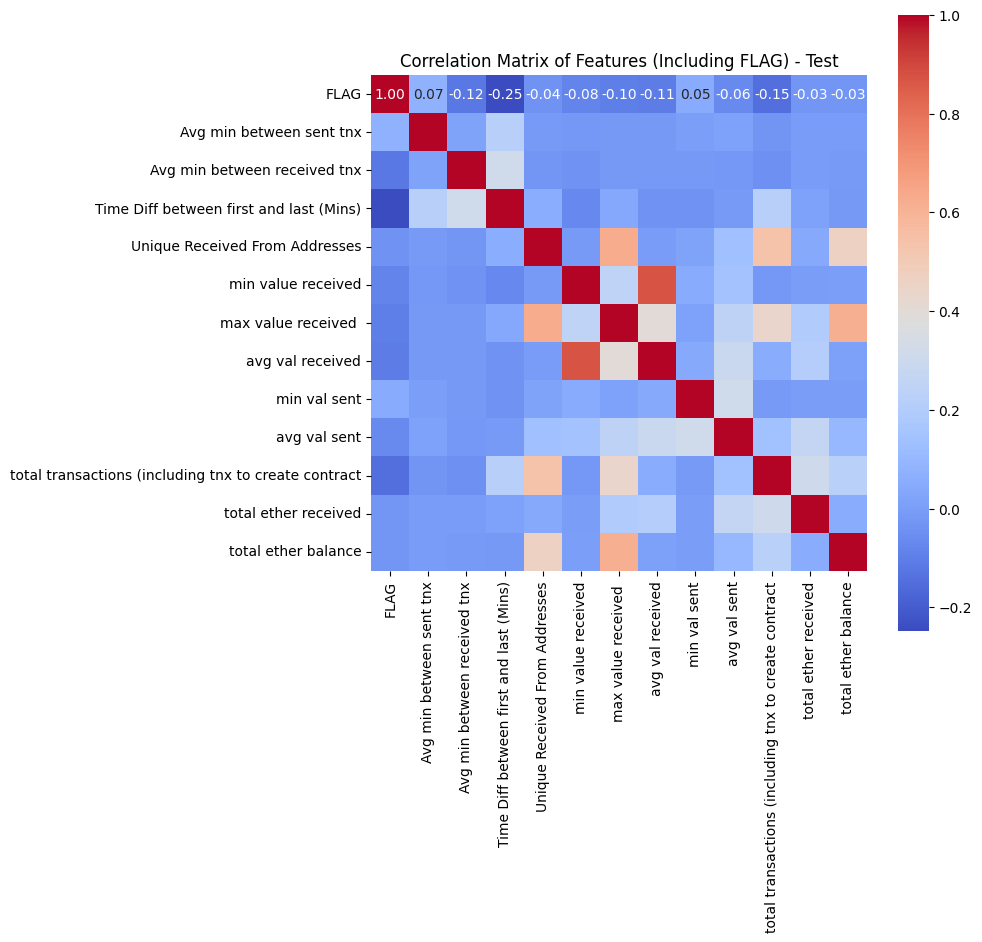

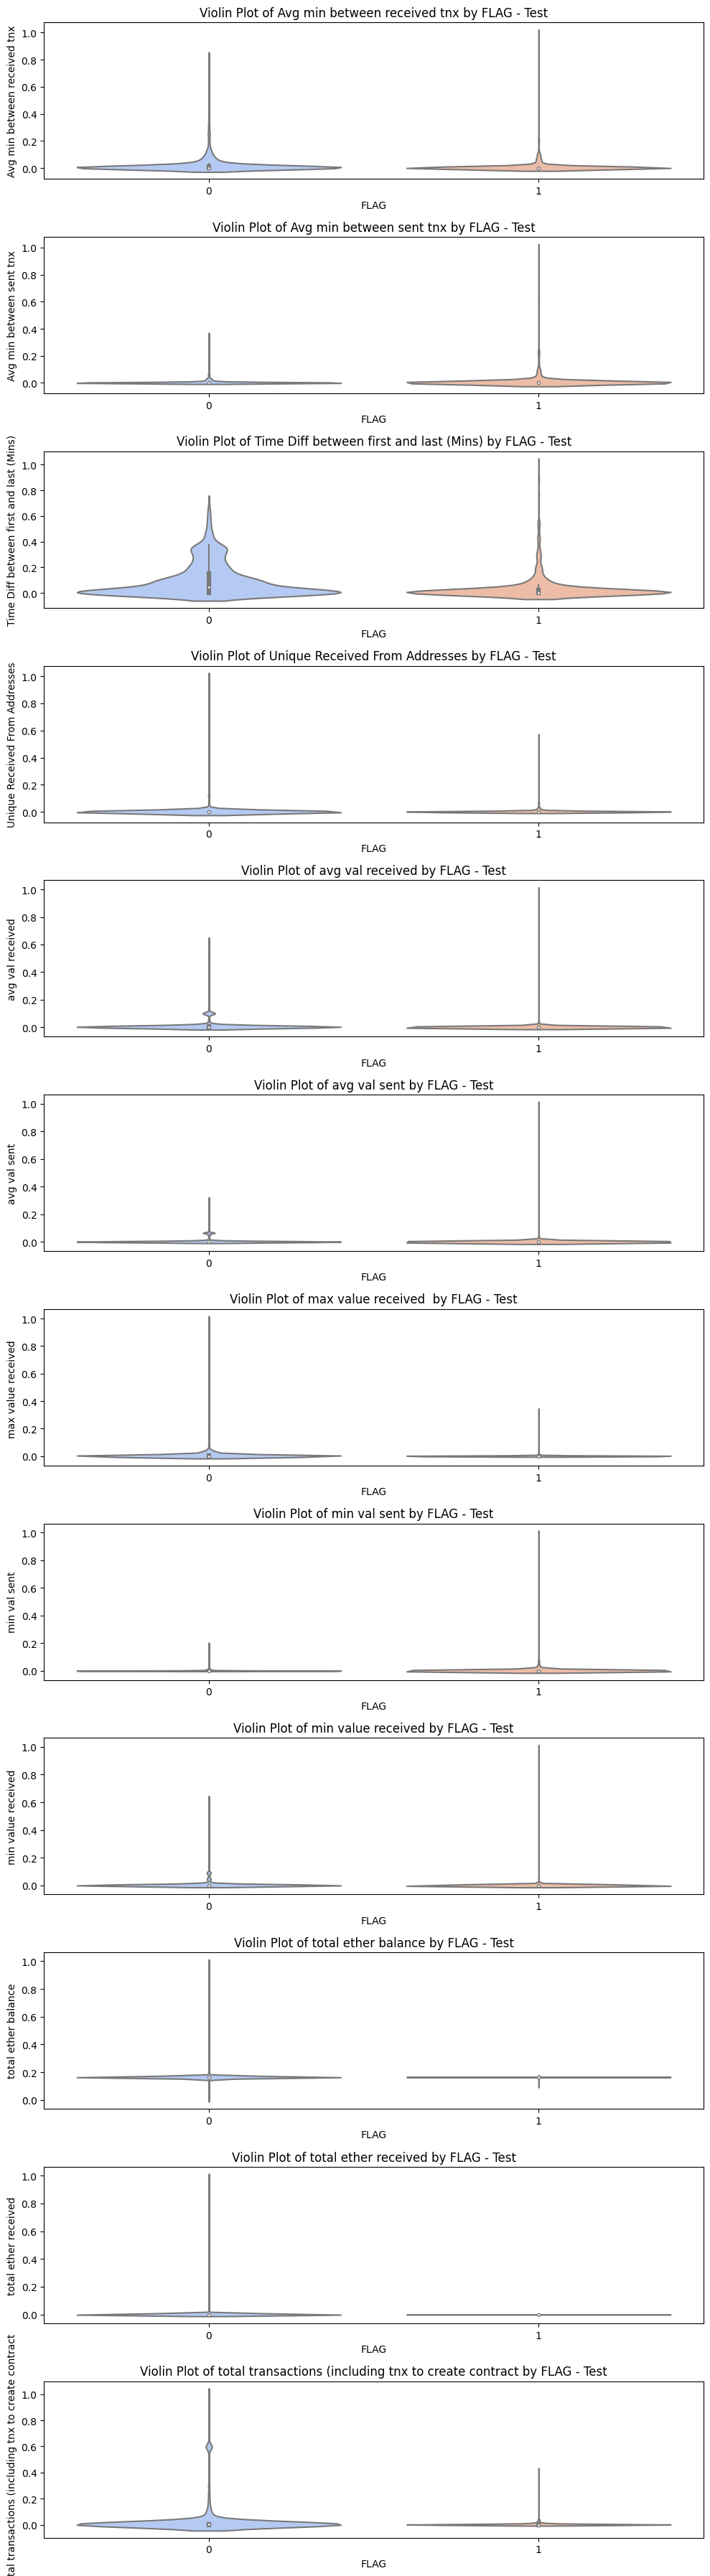

In [41]:
for dataset, name in zip([train_data, val_data, test_data], ["Train", "Validation", "Test"]):
    plot_correlation_matrix(dataset, name)
    plot_violin_plots(dataset, name)

#### **Observations**

##### **1. FLAG Correlation with Other Features:**
- The `FLAG` variable (indicating fraud or anomaly) has relatively low correlations with most features.
- The highest correlation (negative) appears to be with **"Time Diff between first and last (Mins)"** (~ -0.25), suggesting that fraudulent or flagged accounts tend to have transactions occurring over a shorter duration.
- There is a small positive correlation with **"Avg min between sent tnx"** (~0.07), meaning flagged accounts might have slightly larger gaps between sent transactions.

##### **2. Relationships Among Transaction Features:**
- **"Total transactions (including tnx to create contract)"** has a strong positive correlation with **"Total ether received"** and **"Total ether balance"**, which is expected as more transactions typically result in higher balances.
- **"Min value received"**, **"Max value received"**, and **"Avg value received"** are positively correlated with each other, indicating that accounts receiving large transactions tend to receive higher average amounts.

##### **3. Weak Correlations Across Features:**
- Most correlations are weak, meaning individual features may not strongly influence each other.
- This suggests that fraud detection (FLAG) is not heavily dependent on any single variable.

### **4.2**

#### **Splitting into X and y**

In [42]:
X_train = train_data.drop(columns=['FLAG'])
y_train = train_data['FLAG']

X_val = val_data.drop(columns=['FLAG'])
y_val = val_data['FLAG']

X_test = test_data.drop(columns=['FLAG'])
y_test = test_data['FLAG']

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(9059, 12) (9059,)
(2265, 12) (2265,)
(2831, 12) (2831,)


#### **Decision Tree**

In [43]:
class TreeNode:
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain):
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.left = None
        self.right = None
    
    def node_def(self):
        return f"Feature {self.feature_idx} < {self.feature_val:.2f}, IG: {self.information_gain:.4f}"

class DecisionTree():
    
    def __init__(self, max_depth=4, min_samples_split=1, min_information_gain=0.0, criterion="entropy"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_information_gain = min_information_gain
        self.criterion = criterion
        self.tree = None

    def compute_entropy(self, labels):
        labels = labels.astype(int)
        counts = np.bincount(labels)
        probabilities = counts / len(labels)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def compute_gini(self, labels):
        labels = labels.astype(int)
        counts = np.bincount(labels)
        probabilities = counts / len(labels)
        return 1 - np.sum([p ** 2 for p in probabilities])

    def impurity(self, labels):
        return self.compute_entropy(labels) if self.criterion == "entropy" else self.compute_gini(labels)

    def split_data(self, data, feature_idx, threshold):
        left_split = data[data[:, feature_idx] < threshold]
        right_split = data[data[:, feature_idx] >= threshold]
        return left_split, right_split

    def best_split(self, data):
        best_feature, best_value, best_impurity = None, None, float("inf")
        best_left, best_right = None, None

        for feature_idx in range(data.shape[1] - 1):
            threshold = np.median(data[:, feature_idx])
            left, right = self.split_data(data, feature_idx, threshold)
            
            if len(left) < self.min_samples_split or len(right) < self.min_samples_split:
                continue
            
            weighted_impurity = (len(left) * self.impurity(left[:, -1]) + len(right) * self.impurity(right[:, -1])) / len(data)
            
            if weighted_impurity < best_impurity:
                best_feature, best_value, best_impurity = feature_idx, threshold, weighted_impurity
                best_left, best_right = left, right
        
        return best_left, best_right, best_feature, best_value, best_impurity

    def label_distribution(self, labels):
        counts = Counter(labels)
        total = len(labels)
        return {label: count / total for label, count in counts.items()}

    def predict_sample(self, sample):
        node = self.tree
        while isinstance(node, dict) and 'feature' in node:
            node = node['left'] if sample[node['feature']] < node['threshold'] else node['right']
        return node

    def predict_proba(self, X):
        return np.array([self.predict_sample(sample) for sample in X])

    def predict(self, X):
        return np.array([max(self.predict_sample(sample), key=self.predict_sample(sample).get) for sample in X])   
        
    def train(self, X_train, Y_train):
        
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)
        self.tree = self.build_tree(train_data, 0)

    def build_tree(self, data, depth):
        if depth >= self.max_depth or len(data) < self.min_samples_split:
            return self.label_distribution(data[:, -1])
        
        left, right, feature, threshold, impurity = self.best_split(data)
        if left is None or right is None:
            return self.label_distribution(data[:, -1])

        node = {"feature": feature, "threshold": threshold, "left": None, "right": None}
        node["left"] = self.build_tree(left, depth + 1)
        node["right"] = self.build_tree(right, depth + 1)
        
        return node


#### **Comparision**

In [44]:
def compare_implementations(X_train, y_train,X_val, y_val, X_test, y_test, max_depth=4, min_samples_split=2, criterion="entropy"):

    start = time.time()

    custom_dt = DecisionTree(max_depth=max_depth, min_samples_split=2, min_information_gain=0, criterion=criterion)
    custom_dt.train(X_train, y_train)
    custom_train_time = time.time() - start

    
    sklearn_dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=4, criterion=criterion,random_state=21)
    sklearn_dt.fit(X_train, y_train)
    sklearn_train_time = time.time() - start - custom_train_time
    
    custom_train_pred = custom_dt.predict(X_train)
    custom_val_pred = custom_dt.predict(X_val)
    custom_test_pred = custom_dt.predict(X_test)
    custom_train_accuracy = accuracy_score(y_train, custom_train_pred)
    custom_val_accuracy = accuracy_score(y_val, custom_val_pred)
    custom_test_accuracy = accuracy_score(y_test, custom_test_pred)
    
    sklearn_train_pred = sklearn_dt.predict(X_train)
    sklearn_val_pred = sklearn_dt.predict(X_val)
    sklearn_test_pred = sklearn_dt.predict(X_test)
    sklearn_train_accuracy = accuracy_score(y_train, sklearn_train_pred)
    sklearn_val_accuracy = accuracy_score(y_val, sklearn_val_pred)
    sklearn_test_accuracy = accuracy_score(y_test, sklearn_test_pred)
    
    print("\nAccuracy Comparison:")
    print("-" * 50)
    print("Custom Implementation:")
    print(f"Training Accuracy: {custom_train_accuracy:.4f}")
    print(f"Validation Accuracy: {custom_val_accuracy:.4f}")
    print(f"Testing Accuracy:  {custom_test_accuracy:.4f}")
    print(f"Train Time: {custom_train_time:.4f}")
    print("\nScikit-learn Implementation:")
    print(f"Training Accuracy: {sklearn_train_accuracy:.4f}")
    print(f"Validation Accuracy: {sklearn_val_accuracy:.4f}")
    print(f"Testing Accuracy:  {sklearn_test_accuracy:.4f}")
    print(f"Train Time: {sklearn_train_time:.4f}")
    
    return custom_dt, sklearn_dt

custom_dt, sklearn_dt = compare_implementations(X_train.values, y_train.values, X_val.values, y_val.values, X_test.values, y_test.values,
                                                 max_depth=7, min_samples_split=5,criterion="entropy")


Accuracy Comparison:
--------------------------------------------------
Custom Implementation:
Training Accuracy: 0.8736
Validation Accuracy: 0.7925
Testing Accuracy:  0.8174
Train Time: 0.0903

Scikit-learn Implementation:
Training Accuracy: 0.8850
Validation Accuracy: 0.6940
Testing Accuracy:  0.8336
Train Time: 0.0484


#### **HyperParameter Tuning**

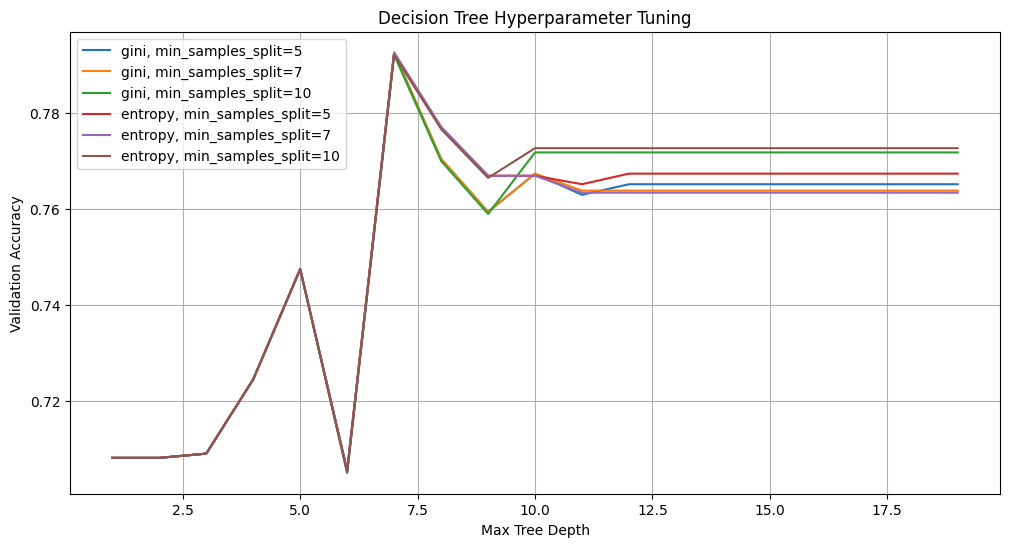

In [45]:
max_depth_values = range(1, 20)
min_samples_split_values = [5, 7, 10]
criteria = ["gini", "entropy"]

results = {}

for criterion in criteria:
    for min_samples_split in min_samples_split_values:
        train_accuracies = []
        val_accuracies = []
        
        for depth in max_depth_values:

            custom_dt = DecisionTree(max_depth=depth, min_samples_split=min_samples_split, min_information_gain=0, criterion=criterion)
            custom_dt.train(X_train.values, y_train.values)
            
            # Evaluate performance
            train_acc = accuracy_score(y_train.values, custom_dt.predict(X_train.values))
            val_acc = accuracy_score(y_val.values, custom_dt.predict(X_val.values))
            
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
        
        results[(criterion, min_samples_split)] = (train_accuracies, val_accuracies)

plt.figure(figsize=(12, 6))

for (criterion, min_samples_split), (train_acc, val_acc) in results.items():
    plt.plot(max_depth_values, val_acc, label=f"{criterion}, min_samples_split={min_samples_split}")

plt.xlabel("Max Tree Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision Tree Hyperparameter Tuning")
plt.legend()
plt.grid()
plt.show()

#### **Observations**

1. **Max Depth Tradeoff:** Increasing depth improves training accuracy but eventually harms validation accuracy due to overfitting.
2. **Min Samples Split Effect:** Larger values prevent small, noisy splits, enhancing generalization. At depth = 10 or more the num_split = 10 performs better than other.
3. **Entropy v/s Gini:** The optimal criterion depends on the dataset distribution and how well the information gain (entropy) separates classes. In our database ```entropy``` performs better.

### **Model Visualisation**

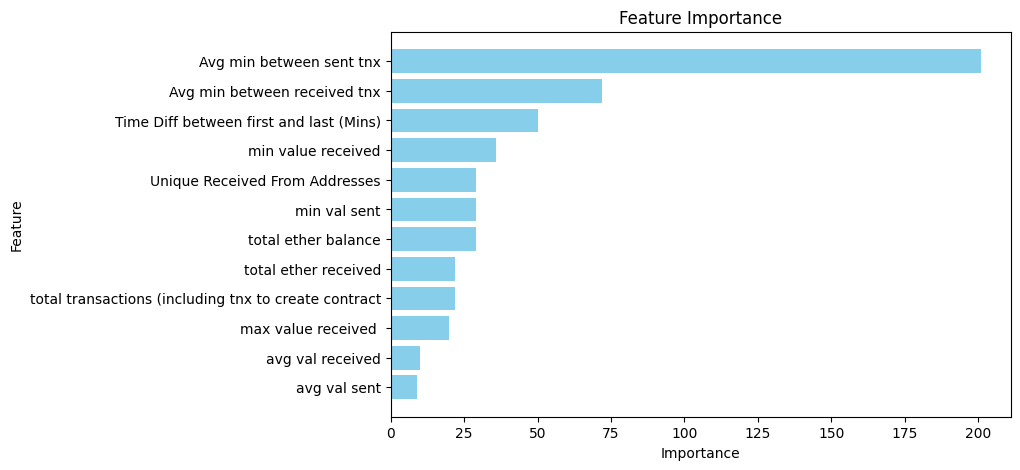

In [46]:
def plot_feature_importance(tree, feature_names):
    feature_importance = Counter()

    def traverse(node):
        if isinstance(node, dict) and 'feature' in node:
            feature_importance[node['feature']] += 1
            if 'left' in node and node['left'] is not None:
                traverse(node['left'])
            if 'right' in node and node['right'] is not None:
                traverse(node['right'])

    traverse(tree)

    features, importance = zip(*sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(8, 5))
    plt.barh([feature_names[f] for f in features], importance, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

feature_names = X_train.columns
plot_feature_importance(custom_dt.tree, feature_names)


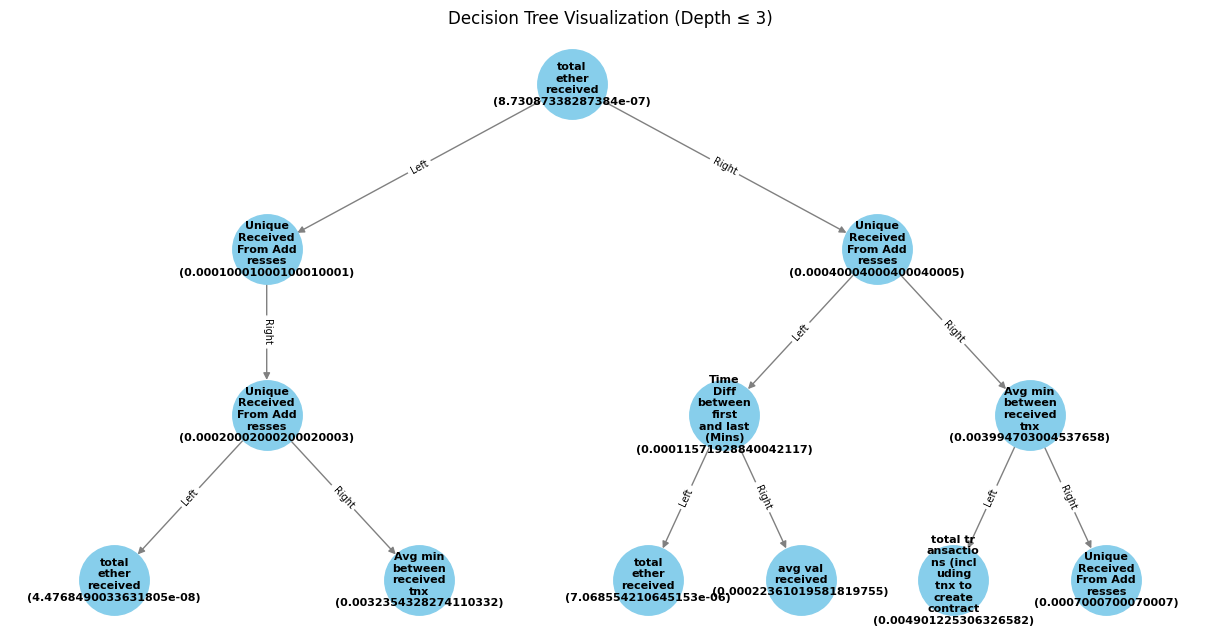

In [47]:
def shorten_label(text, max_len=10):
    """Shortens or wraps long feature names to improve readability."""
    return "\n".join(textwrap.wrap(text, max_len))

def hierarchical_pos(G, root=0, width=1., vert_gap=0.2, xcenter=0.5):
    """Generates hierarchical positions for a tree structure."""
    pos = {}
    
    def _hierarchical_pos(node, x=xcenter, y=1, dx=width):
        pos[node] = (x, y)
        children = list(G.neighbors(node))
        if len(children) == 1:
            _hierarchical_pos(children[0], x, y - vert_gap, dx)
        elif len(children) > 1:
            left_x = x - dx / 2
            right_x = x + dx / 2
            _hierarchical_pos(children[0], left_x, y - vert_gap, dx / 2)
            _hierarchical_pos(children[1], right_x, y - vert_gap, dx / 2)
    
    _hierarchical_pos(root)
    return pos

def plot_tree(tree, feature_names, max_depth=3):
    G = nx.DiGraph()
    labels = {}

    def traverse(node, depth=0, parent=None, edge_label=""):
        if depth > max_depth or not isinstance(node, dict) or 'feature' not in node:
            return
        
        feature = shorten_label(feature_names[node['feature']], max_len=8)
        threshold = node.get('threshold', '')
        node_label = f"{feature}\n({threshold})" if threshold else feature
        node_id = len(labels)

        labels[node_id] = node_label

        if parent is not None:
            G.add_edge(parent, node_id, label=edge_label)

        if 'left' in node and node['left'] is not None:
            traverse(node['left'], depth + 1, node_id, "Left")
        if 'right' in node and node['right'] is not None:
            traverse(node['right'], depth + 1, node_id, "Right")

    traverse(tree)

    pos = hierarchical_pos(G)
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2500, node_color="skyblue", font_size=8, font_weight="bold", edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Decision Tree Visualization (Depth ≤ {max_depth})", fontsize=12)
    plt.show()

plot_tree(custom_dt.tree, X_train.columns, max_depth=3)
